# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from utils import *

from grace.utils import *

# Initialization

In [2]:
calib_params = load_json('config/calib/calib_params.json')

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    corners = corners.squeeze()
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for u,v in corners:
        z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, y, z])
        
    return np.array(obj_pts)

def get_depth_mean(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    return depth_mean

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    # Estimate the extrinsic matrix
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
    retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)
    
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    
    # Homogeneous Coordinates
    H = np.eye(4)
    H[:3,:3] = rotation_matrix
    H[:3,-1] = tvec.T
    
    # Camera Pose
    T = np.linalg.inv(H)
    return T
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

# Loading of Data

## Pickle Data

In [3]:
filename = 'pan_baseline_sweep_pickle_20240318_004730_332152.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'pan_baseline_sweep',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

## Preprocessing



In [6]:
# Assigning next step data for tminus1

pickle_df['theta_left_pan_cmd_tminus1'] = [0] + pickle_df['theta_left_pan_cmd'][:-1].tolist() 
pickle_df['theta_right_pan_cmd_tminus1'] = [0] + pickle_df['theta_right_pan_cmd'][:-1].tolist() 
pickle_df['theta_tilt_cmd_tminus1'] = [0] + pickle_df['theta_tilt_cmd'][:-1].tolist()
pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [7]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [8]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_pan_angle', 'chest_tilt_angle', 'plan_phi_left_pan',
       'plan_phi_right_pan', 'plan_phi_tilt', 'chest_img', 'left_eye_img',
       'right_eye_img', 'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'theta_left_pan_cmd',
       'theta_right_pan_cmd', 'theta_tilt_cmd', 'theta_left_pan_cmd_tminus1',
       'theta_right_pan_cmd_tminus1', 'theta_tilt_cmd_tminus1',
       'chess_idx_tminus1', 'theta_left_pan_tminus1',
       'theta_right_pan_tminus1', 'theta_tilt_tminus1',
       'plan_phi_left_pan_tminus2', 'plan_phi_r

In [9]:
# Dropping the first row
pickle_df = pickle_df.drop(np.arange(0,2)).reset_index(drop=True)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.351562,-0.263672,0.175781,288.758057,42.386253,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.358441,-0.436274,-0.050733,-0.217314,-0.302299,-0.048556,1,1,1
1,6,-16.875000,-0.263672,0.175781,371.514496,43.106400,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.217314,-0.302299,-0.048556,-0.069076,-0.157696,-0.045580,3,3,3
2,8,0.527344,-0.263672,0.175781,452.400726,43.264652,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069076,-0.157696,-0.045580,0.076688,-0.011927,-0.041414,3,3,3
3,6,-16.787109,-0.263672,0.175781,532.063293,43.542030,-360.6,-224.7,-222.3,-235.9,...,0.175781,0.076688,-0.011927,-0.041414,0.219438,0.133977,-0.041196,3,3,3
4,4,1.494141,-0.263672,0.175781,452.421814,43.279144,-360.6,-224.7,-222.3,-235.9,...,0.175781,0.219438,0.133977,-0.041196,0.076688,-0.011927,-0.041414,2,2,2


# Filtering

## Valid Chessboard Points

In [10]:
pickle_df[pickle_df['theta_left_pan_cmd']>-1]

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.351562,-0.263672,0.175781,288.758057,42.386253,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.358441,-0.436274,-0.050733,-0.217314,-0.302299,-0.048556,1,1,1
2,8,0.527344,-0.263672,0.175781,452.400726,43.264652,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069076,-0.157696,-0.045580,0.076688,-0.011927,-0.041414,3,3,3
4,4,1.494141,-0.263672,0.175781,452.421814,43.279144,-360.6,-224.7,-222.3,-235.9,...,0.175781,0.219438,0.133977,-0.041196,0.076688,-0.011927,-0.041414,2,2,2
6,0,2.548828,-0.263672,0.175781,288.715607,42.399857,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069076,-0.157696,-0.045580,-0.217410,-0.302140,-0.047477,0,0,0
8,4,3.515625,-0.263672,0.175781,288.804413,42.379070,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.358405,-0.436356,-0.051282,-0.217410,-0.302140,-0.047477,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,8,5.537109,-0.263672,0.175781,452.403778,43.276474,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069135,-0.157623,-0.045054,0.076822,-0.012056,-0.042446,3,3,3
124,4,6.503906,-0.263672,0.175781,452.394714,43.289604,-360.6,-224.7,-222.3,-235.9,...,0.175781,0.219438,0.133977,-0.041196,0.076555,-0.011799,-0.040387,2,2,3
126,0,7.470703,-0.263672,0.175781,288.739410,42.381027,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069076,-0.157696,-0.045580,-0.217362,-0.302220,-0.048015,0,0,0
128,4,8.437500,-0.263672,0.175781,288.757233,42.392200,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.358369,-0.436437,-0.051832,-0.217362,-0.302220,-0.048015,1,1,1


In [11]:
filt_df = pickle_df[(pickle_df['theta_left_pan_cmd']>-1) & (pickle_df['theta_left_pan_cmd']<5) ].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.351562,-0.263672,0.175781,288.758057,42.386253,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.358441,-0.436274,-0.050733,-0.217314,-0.302299,-0.048556,1,1,1
1,8,0.527344,-0.263672,0.175781,452.400726,43.264652,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069076,-0.157696,-0.045580,0.076688,-0.011927,-0.041414,3,3,3
2,4,1.494141,-0.263672,0.175781,452.421814,43.279144,-360.6,-224.7,-222.3,-235.9,...,0.175781,0.219438,0.133977,-0.041196,0.076688,-0.011927,-0.041414,2,2,2
3,0,2.548828,-0.263672,0.175781,288.715607,42.399857,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.069076,-0.157696,-0.045580,-0.217410,-0.302140,-0.047477,0,0,0
4,4,3.515625,-0.263672,0.175781,288.804413,42.379070,-360.6,-224.7,-222.3,-235.9,...,0.175781,-0.358405,-0.436356,-0.051282,-0.217410,-0.302140,-0.047477,1,1,1


In [12]:
filt_df['theta_left_pan_cmd'].unique()

array([0., 1., 2., 3., 4.])

# Extrinsic Matrix

## Initialization

In [13]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")

In [14]:
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

In [15]:
# Example

pan_filt_df = filt_df[filt_df['chess_idx_tminus1']==6].reset_index(drop=True)
chest_img = pan_filt_df['chest_img'][0]
depth_img = pan_filt_df['depth_img'][0]

In [16]:
# Get Chess Corners and Object Points

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)
obj_pts = get_chess_obj_pts(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)

(190.0, 70.0)

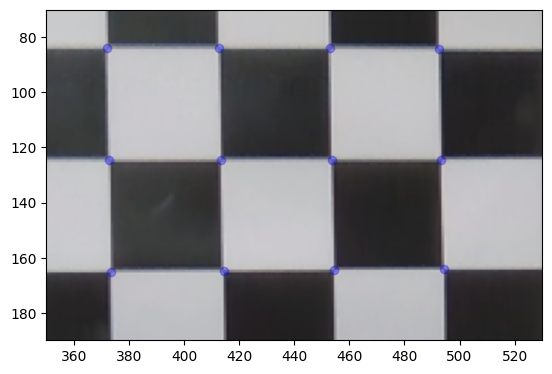

In [17]:
plt.figure()
plt.imshow(chest_img)
for u,v in corners:
    plt.scatter(u,v, color='blue',alpha=0.3)
plt.xlim([350, 530])
plt.ylim([190, 70])

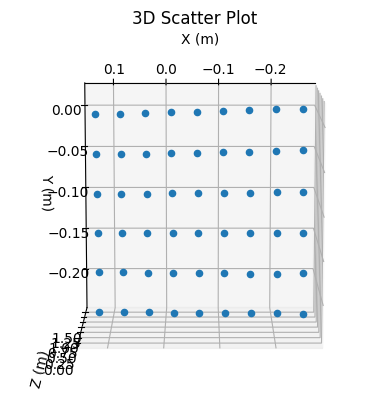

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and an axes object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0])

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Scatter Plot')
ax.set_zlim([-0.2,1.7])
ax.view_init(elev=-80, azim=90)

# Show the plot
plt.show()

## List of Camera Pose

In [19]:
left_eye_camera_mtx

array([[565.63601616,   0.        , 302.45664072],
       [  0.        , 564.7179812 , 215.54188413],
       [  0.        ,   0.        ,   1.        ]])

In [20]:
# Looping: Left Eye Image

img_list = pan_filt_df['left_eye_img'].tolist()
T_left_list = []
for img in img_list:
    T_left_list.append(get_camera_pose(img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))

In [21]:
%matplotlib widget

(-0.2, 2.0)

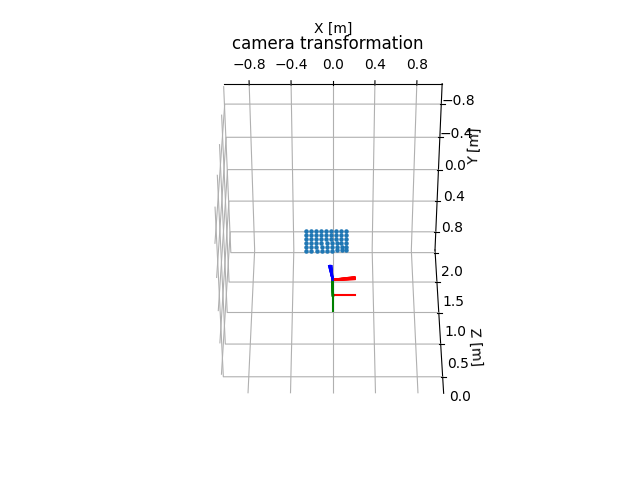

In [22]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Left Poses
for T in T_left_list:
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)
# Plot Right Poses
# for T in T_right_list:
#     ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=0.2)

ax.view_init(elev=-50, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

# Projection from Camera to World

In [23]:
# Camera Intrinsic Parameters
fx = camera_mtx['left_eye']['camera_matrix'][0][0]
fy = camera_mtx['left_eye']['camera_matrix'][1][1]
cx = camera_mtx['left_eye']['camera_matrix'][0][2]
cy = camera_mtx['left_eye']['camera_matrix'][1][2]

# Gaze Center
gx = calib_params['left_eye']['x_center']
gy = calib_params['left_eye']['y_center']

print(gx, gy)

360.6 224.7


In [24]:
# Normalized Camera Coordinates

nx = (gx-cx)/fx
ny = (gy-cy)/fy
print(nx, ny)

0.10279288733190066 0.01621714940002337


In [25]:
T_left_list

[array([[ 0.99044051,  0.01407221, -0.13722089, -0.00266456],
        [-0.02119012,  0.99849671, -0.05054988, -0.18349904],
        [ 0.13630326,  0.05297437,  0.98924978, -0.00150465],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.99390679,  0.01450375, -0.10926544, -0.00323832],
        [-0.02030629,  0.99843118, -0.05218087, -0.18265204],
        [ 0.1083372 ,  0.05408169,  0.99264204, -0.00170278],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.99415563,  0.01456667, -0.10696917, -0.00310713],
        [-0.02027952,  0.99841423, -0.05251448, -0.18219703],
        [ 0.10603458,  0.05437685,  0.99287453, -0.00178684],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.99679473,  0.01495841, -0.07859076, -0.00346927],
        [-0.01923028,  0.99836205, -0.05388328, -0.18155684],
        [ 0.07765603,  0.05522189,  0.99544969, -0.00187362],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),


In [26]:
# Calculation of Z_camera

# Given
z_w = 1.5  # unit in meters 
z_w = obj_pts[0][2]   # actual value
T_inv = T_left_list[0]
r20 = T_inv[2][0]
r21 = T_inv[2][1]
r22 = T_inv[2][2]
t3 = T_inv[2][3]

z_c = (z_w-t3)/(r20*nx+r21*ny+r22)

print(T_inv)
print('z_c:', z_c)

[[ 0.99044051  0.01407221 -0.13722089 -0.00266456]
 [-0.02119012  0.99849671 -0.05054988 -0.18349904]
 [ 0.13630326  0.05297437  0.98924978 -0.00150465]
 [ 0.          0.          0.          1.        ]]
z_c: 0.6936284580531908


In [27]:
# Calculation of Gaze Center World Point

X_c = np.array([nx*z_c, ny*z_c, z_c, 1]).T
X_w = T_inv @ X_c
print(X_w)

[-0.0270681  -0.20884096  0.69498148  1.        ]


(-0.2, 2.0)

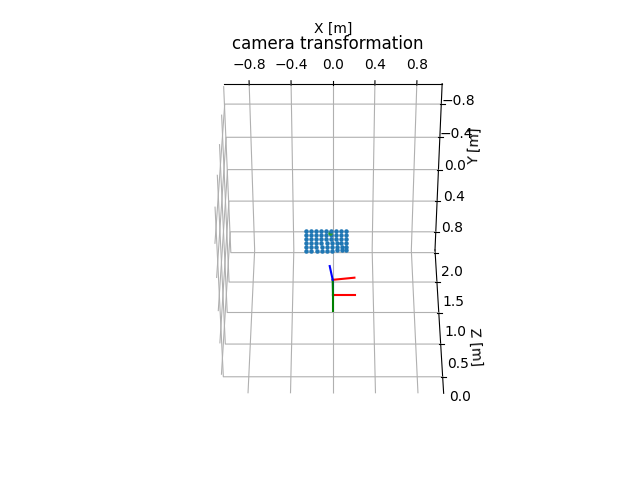

In [28]:
# Plotting

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')
    
# Plot 3D Chess Points
ax.scatter(X_w[0], X_w[1], X_w[2], color=colors[2], marker='.')

# Plot Left Poses
ax = pr.plot_basis(ax, T_inv[:3,:3], T_inv[:3,-1], s=0.2)

ax.view_init(elev=-50, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

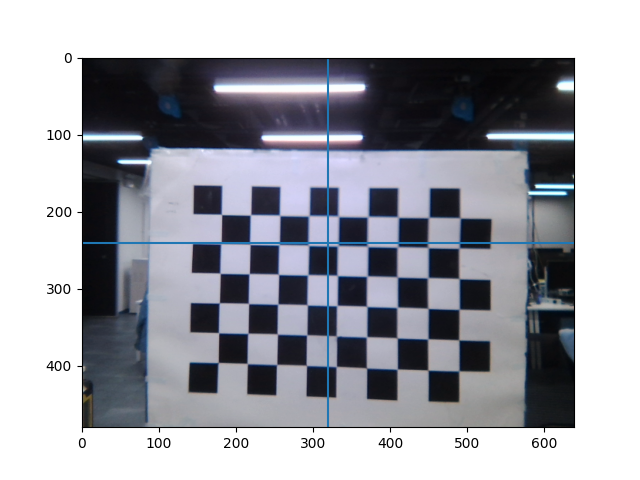

In [29]:
plt.figure()
plt.imshow(img_list[0])
plt.axvline(320)
plt.axhline(240)

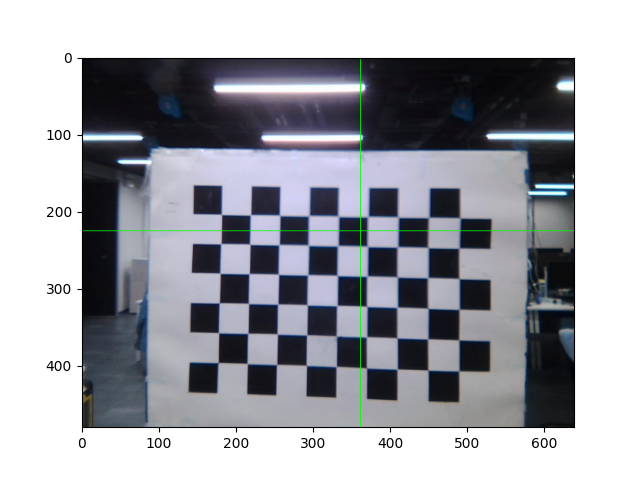

In [30]:
# Left Eye Cam Projection

plt.figure()

img_list = pan_filt_df['left_eye_img'].tolist()
img = img_list[0]

# Estimate the extrinsic matrix
left_corners = get_chess_corners(img, left_eye_camera_mtx, left_eye_dist_coef)
retval, rvec, tvec = cv2.solvePnP(obj_pts, left_corners, left_eye_camera_mtx, left_eye_dist_coef)

# Convert the rotation vector to a rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Project Image
points_3d = obj_pts
R = rotation_matrix
t = tvec

gaze_center_3d = X_w[:3].T

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, left_eye_camera_mtx, left_eye_dist_coef)
points_2d_undistorted = points_2d_undistorted.squeeze()

# Add the gaze center
points_2d_gaze_center, _ = cv2.projectPoints(gaze_center_3d, rvec, tvec, left_eye_camera_mtx, left_eye_dist_coef)
points_2d_gaze_center = points_2d_gaze_center.squeeze()

# Project 3D Axes
left_disp2 = copy.deepcopy(img)
eye = 'left_eye'
left_disp2 = cv2.line(left_disp2, (round(calib_params[eye]['x_center']), 0), (round(calib_params[eye]['x_center']), 480), (0,255,0))
left_disp2 = cv2.line(left_disp2, (0, round(calib_params[eye]['y_center'])), (640, round(calib_params[eye]['y_center'])), (0,255,0))
# img = cv2.drawMarker(img, (round(calib_params[eye]['x_center']), round(calib_params[eye]['y_center'])), color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=15, thickness=2)


# Display
plt.imshow(left_disp2)

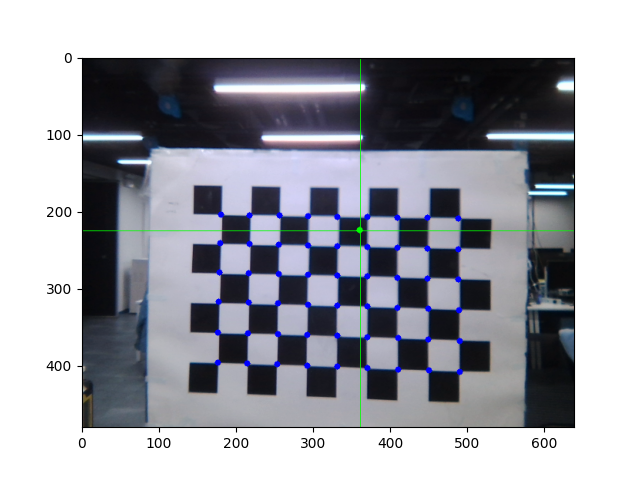

In [31]:
# Left Eye Cam Projection

plt.figure()

img_list = pan_filt_df['left_eye_img'].tolist()
img = img_list[0]

# Estimate the extrinsic matrix
left_corners = get_chess_corners(img, left_eye_camera_mtx, left_eye_dist_coef)
retval, rvec, tvec = cv2.solvePnP(obj_pts, left_corners, left_eye_camera_mtx, left_eye_dist_coef)

# Convert the rotation vector to a rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Project Image
points_3d = obj_pts
R = rotation_matrix
t = tvec

gaze_center_3d = X_w[:3].T

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, left_eye_camera_mtx, left_eye_dist_coef)
points_2d_undistorted = points_2d_undistorted.squeeze()

# Add the gaze center
points_2d_gaze_center, _ = cv2.projectPoints(gaze_center_3d, rvec, tvec, left_eye_camera_mtx, left_eye_dist_coef)
points_2d_gaze_center = points_2d_gaze_center.squeeze()

# Project 3D Axes
left_disp2 = copy.deepcopy(img)
eye = 'left_eye'
left_disp2 = cv2.line(left_disp2, (round(calib_params[eye]['x_center']), 0), (round(calib_params[eye]['x_center']), 480), (0,255,0))
left_disp2 = cv2.line(left_disp2, (0, round(calib_params[eye]['y_center'])), (640, round(calib_params[eye]['y_center'])), (0,255,0))
# img = cv2.drawMarker(img, (round(calib_params[eye]['x_center']), round(calib_params[eye]['y_center'])), color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=15, thickness=2)

# Draw projected points on the image
for i in range(points_2d_undistorted.shape[0]):
    x, y = points_2d_undistorted[i]
    left_disp2 = cv2.circle(left_disp2, (int(x), int(y)), 4, (0, 0, 255), -1)

left_disp2 = cv2.circle(left_disp2, (int(points_2d_gaze_center[0]), int(points_2d_gaze_center[1])), 4, (0, 255, 0), -1)

# Display
plt.imshow(left_disp2)

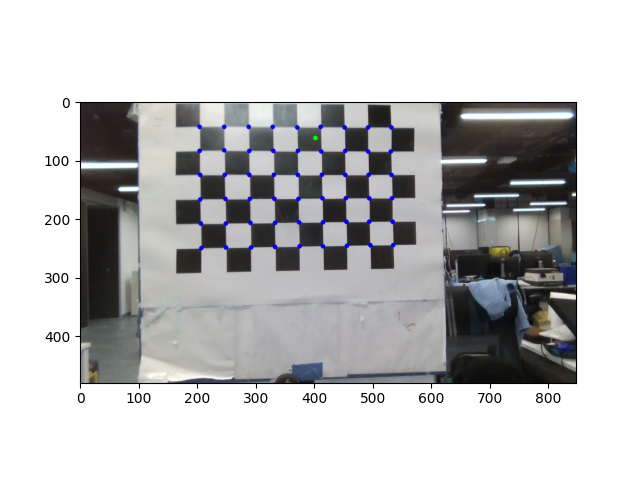

In [32]:
# Chest Cam Projection

plt.figure()

img_list = pan_filt_df['chest_img'].tolist()
img = img_list[0]

rvec = np.zeros((3,1))
tvec = np.zeros((3,1))
points_3d = obj_pts
gaze_center_3d = X_w[:3].T

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, chest_cam_camera_mtx, chest_cam_dist_coef)
points_2d_undistorted = points_2d_undistorted.squeeze()

# Add the gaze center
points_2d_gaze_center, _ = cv2.projectPoints(gaze_center_3d, rvec, tvec, chest_cam_camera_mtx, chest_cam_dist_coef)
points_2d_gaze_center = points_2d_gaze_center.squeeze()

# Project 3D Axes
chest_disp = copy.deepcopy(img)

# Draw projected points on the image
for i in range(points_2d_undistorted.shape[0]):
    x, y = points_2d_undistorted[i]
    chest_disp = cv2.circle(chest_disp, (int(x), int(y)), 4, (0, 0, 255), -1)

chest_disp = cv2.circle(chest_disp, (int(points_2d_gaze_center[0]), int(points_2d_gaze_center[1])), 4, (0, 255, 0), -1)

# Display
plt.imshow(chest_disp)

In [ ]:
for T in T_left_list:
    print(T)

# Coordinate Transformation

In [ ]:
def get_chess_obj_pts_world(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for u,v in corners:
        z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, z, -y])
        
    return np.array(obj_pts)
    
def depth_to_world(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,z,-y

In [ ]:
# Get Chess Corners and Object Points

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)
obj_pts_world = get_chess_obj_pts_world(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)

In [ ]:
# Looping: Left Eye Image

img_list = pan_filt_df['left_eye_img'].tolist()
T_left_list = []
for img in img_list:
    T_left_list.append(get_camera_pose(img, obj_pts_world, left_eye_camera_mtx, left_eye_dist_coef))

In [ ]:
# Looping: Right Eye Image

img_list = pan_filt_df['right_eye_img'].tolist()
T_right_list = []
for img in img_list:
    T_right_list.append(get_camera_pose(img, obj_pts_world, right_eye_camera_mtx, right_eye_dist_coef))

In [ ]:
T_conv = np.zeros((3,3))
T_conv[0,0] = 1
T_conv[1,2] = -1
T_conv[2,1] = 1
T_conv

In [ ]:
# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in obj_pts_world:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Left Poses
for T in T_left_list:
    ax = pr.plot_basis(ax, T[:3,:3]@T_conv, T[:3,-1], s=0.2)
# Plot Right Poses
for T in T_right_list:
    ax = pr.plot_basis(ax, T[:3,:3]@T_conv, T[:3,-1], s=0.2)

# ax.view_init(elev=-50, azim=-90)
ax.set_title("camera transformation")

# ax.set_zlim([-0.2, 2.0])

In [ ]:
left_cam_pose_list = []
for T in T_left_list:
    T_temp = T[:3,:3]@T_conv
    T[:3,:3]= T_temp
    left_cam_pose_list.append(T)

In [ ]:
left_loc_list = []
for T in T_left_list:
    left_loc_list.append(T[:3,-1])
left_loc_list = np.array(left_loc_list)
left_loc_list[:5]

In [ ]:
right_loc_list = []
for T in T_right_list:
    right_loc_list.append(T[:3,-1])
right_loc_list = np.array(right_loc_list)
right_loc_list[:5]

In [ ]:
val = math.dist(left_loc_list[0,:], right_loc_list[0,:])
print('Left Eye - Right Eye Distance:', val, 'm')

In [ ]:
def draw(img, corners, imgpts):
    corners = corners.squeeze().astype(int)
    imgpts = imgpts.squeeze().astype(int)
    corner = tuple(corners[0])
    img = cv2.line(img, corner, tuple(imgpts[0]), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1]), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2]), (0,0,255), 5)
    return img

In [ ]:
# Chest Cam

plt.figure()

img_list = pan_filt_df['left_eye_img'].tolist()
img = img_list[1]

# Estimate the extrinsic matrix
left_corners = get_chess_corners(img, left_eye_camera_mtx, left_eye_dist_coef)
retval, rvec, tvec = cv2.solvePnP(obj_pts_world, left_corners, left_eye_camera_mtx, left_eye_dist_coef)

# Convert the rotation vector to a rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Project Image
points_3d = obj_pts_world
R = rotation_matrix
t = tvec

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, left_eye_camera_mtx, left_eye_dist_coef)

# Project 3D Axes
left_disp2 = copy.deepcopy(img)

# Draw projected points on the image
for i in range(points_2d_undistorted.shape[0]):
    x, y = points_2d_undistorted[i, 0]
    left_disp2 = cv2.circle(left_disp2, (int(x), int(y)), 4, (255, 0, 0), -1)

# Display
plt.imshow(left_disp2)
del left_disp2

In [ ]:
plt.figure()
sns.kdeplot(left_loc_list[:,0]*100, fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.6)
plt.xlim([-0.8, 0.8])
plt.xlabel('X_w (cm)')
plt.title('X Translation')

In [ ]:
plt.figure()
sns.kdeplot(left_loc_list[:,1]*100, fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.6)
plt.xlabel('Y_w (cm)')
plt.title('Y Translation')

In [ ]:
plt.figure()
sns.kdeplot(left_loc_list[:,2]*100, fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.6)
plt.xlabel('Z_w (cm)')
plt.title('Z Translation')

In [ ]:
plt.figure()
plt.hist(left_loc_list[:,0])

In [ ]:
plt.figure()
plt.hist(left_loc_list[:,1])

In [ ]:
plt.figure()
plt.hist(left_loc_list[:,2])

# Left Eye Optical Center and Gaze Center

In [ ]:
# Center
cx = camera_mtx['left_eye']['camera_matrix'][0][2]
cy = camera_mtx['left_eye']['camera_matrix'][1][2]
gx = calib_params['left_eye']['x_center']
gy = calib_params['left_eye']['y_center']

# Plot
plt.figure()
plt.scatter(cx, cy, color=colors[0])
plt.scatter(gx, gy, color=colors[1])
plt.xlim([0,847])
plt.ylim([399, 0])
plt.legend(['optical center', 'gaze center'])
plt.grid()

# Print
print('cx:', cx)
print('cy:', cy)
print('gx:', gx)
print('gy:', gy)

# Command

In [ ]:
pan_filt_df['chess_idx_tminus1']

In [ ]:
plan = pan_filt_df['theta_right_pan']
plt.figure()
sns.kdeplot(plan, fill=True,alpha=.2, linewidth=1.5, bw_adjust=1.0)
plt.xlabel('Command')
plt.title('Y Translation')

In [ ]:
plan = np.degrees(pan_filt_df['plan_phi_right_pan_tminus1'])/1.6657
plt.figure()
sns.kdeplot(plan, fill=True,alpha=.2, linewidth=1.5, bw_adjust=1.0)
plt.xlabel('Command')
plt.title('Y Translation')

In [ ]:
pan_filt_df[:18]